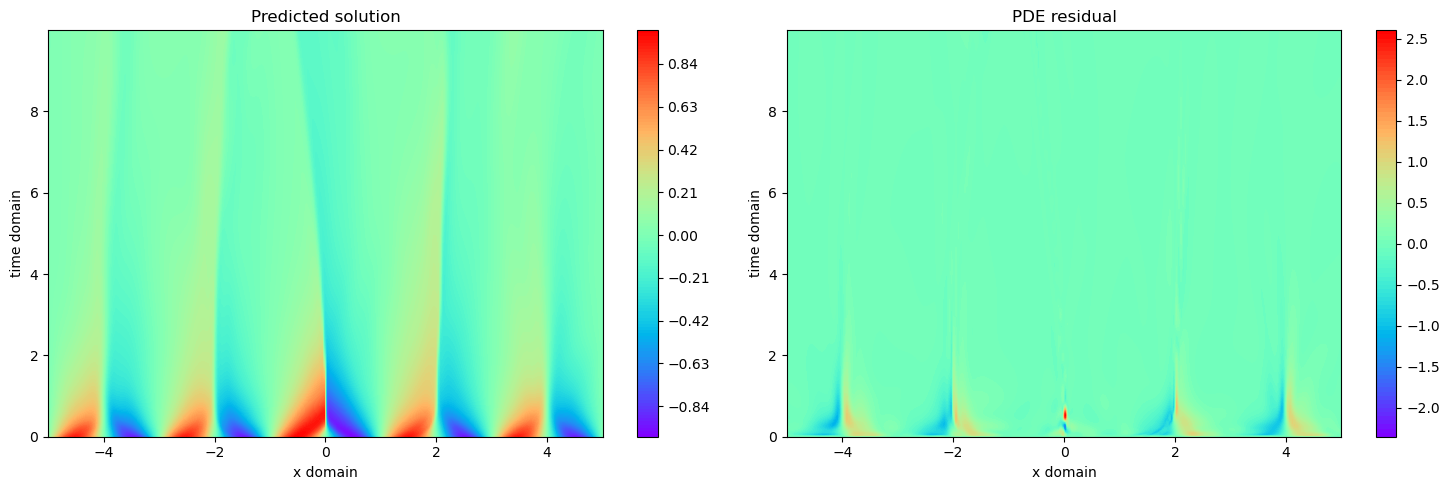

In [12]:
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(-5, 5, 250)  
t = np.linspace(0, 9.99, 250) 
X, T = np.meshgrid(x, t)
X_flat = X.flatten()
T_flat = T.flatten()
grid = np.vstack((X_flat, T_flat)).T


y_pred = model.predict(grid)
y_pred = y_pred.reshape(X.shape)  


f = model.predict(grid, operator=pde)
f = f.reshape(X.shape)  # Reshape to 2D array for contour plot

# Plot the predicted solution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.contourf(X, T, y_pred, levels=150, cmap='rainbow')
plt.colorbar()
plt.title('Predicted solution')
plt.xlabel('x domain')
plt.ylabel('time domain')

# Plot the PDE residual
plt.subplot(1, 2, 2)
plt.contourf(X, T, f, levels=100, cmap='rainbow')
plt.colorbar()
plt.title('PDE residual')
plt.xlabel('x domain')
plt.ylabel('time domain')

plt.tight_layout()
plt.show()


In [13]:
import deepxde as dde
import numpy as np
import tensorflow as tf

# Define the PDE
def pde(X, u):
    du_X = tf.gradients(u, X)[0]
    du_x, du_y, du_t = du_X[:, 0:1], du_X[:, 1:2], du_X[:, 2:3]
    du_xx = tf.gradients(du_x, X)[0][:, 0:1]
    du_yy = tf.gradients(du_y, X)[0][:, 1:2]
    return du_t - 0.5 * (du_xx + du_yy)

# Define the computational geometry: a 2D space domain and a time domain
geom = dde.geometry.Rectangle([-5, -5], [5, 5])
timedomain = dde.geometry.TimeDomain(0, 9.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def initial_condition(x):
    return np.sin(np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])

# Define boundary and initial conditions here
# For example, zero Dirichlet boundary condition and some initial condition
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: initial_condition(x), lambda _, on_initial: on_initial)

# Combine them into a data object
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=4000, num_boundary=2000, num_initial=1000)

# Define the neural network
net = dde.maps.FNN([3] + [20]*3 + [1], "tanh", "Glorot normal")

# Define the model
model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)

# Begin RAR process
err = 1
while err > 0.05:
    # Create a uniform grid for prediction
    X = geomtime.random_points(10000)
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % err)

    # Add the point with the highest residual to the training data
    x_id = np.argmax(err_eq)
    data.add_anchors(X[x_id])

    # Retrain the model
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-5, patience=1000)
    model.compile("adam", lr=1e-3)
    losshistory, train_state = model.train(epochs=100, disregard_previous_best=True, callbacks=[early_stopping])

# Save the model
model.save("model.ckpt")

# Predict the solution in the domain
X = geomtime.random_points(10000)
y_pred = model.predict(X)


Compiling model...
Building feed-forward neural network...
'build' took 0.066050 s

'compile' took 0.670182 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.32e-03, 2.98e-01, 5.06e-01]    [6.32e-03, 2.98e-01, 5.06e-01]    []  
1000      [8.12e-05, 4.90e-05, 2.50e-01]    [8.12e-05, 4.90e-05, 2.50e-01]    []  
2000      [1.32e-03, 5.78e-05, 2.47e-01]    [1.32e-03, 5.78e-05, 2.47e-01]    []  
3000      [2.86e-03, 1.61e-04, 2.35e-01]    [2.86e-03, 1.61e-04, 2.35e-01]    []  
4000      [2.19e-03, 1.74e-04, 2.01e-01]    [2.19e-03, 1.74e-04, 2.01e-01]    []  
5000      [2.01e-03, 2.49e-04, 1.87e-01]    [2.01e-03, 2.49e-04, 1.87e-01]    []  
6000      [1.48e-03, 3.19e-04, 1.76e-01]    [1.48e-03, 3.19e-04, 1.76e-01]    []  
7000      [1.11e-03, 4.23e-04, 1.68e-01]    [1.11e-03, 4.23e-04, 1.68e-01]    []  
8000      [9.49e-04, 4.72e-04, 1.64e-01]    [9.49e-04, 4.72e-04, 1.64e-01]    []  
9000      [9.06e-04, 4.73e-04, 1.